In [ ]:
cd /content/drive/MyDrive/Fun With MNIST/MNIST-2 (Binary Label Classification)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

### Multi Label

In [65]:
def create_dataset(dataset_size):
    '''
    Function to create dataset for multi label classification by horizontally stacking two images.
    Parameters:
            dataset_size = size of the dataset to be created
    Returns : New dataset with two classes in one image and size of the returned dataset will not match with dataset_size variable, since we drop few images.
    '''
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x = np.concatenate((x_train, x_test), axis = 0) #contatenating both train and test dataset to create one large dataset.
    y = np.concatenate((y_train, y_test))
    print('Shape of the dataset after concatinating:')
    print(x.shape, y.shape)

    x_new = []
    y_new = []
    no_of_removes = 0
    for _ in range(dataset_size):
        indices = np.random.randint(0, 70000, size = 2) #randomly selecting two indices for stacking.

        ans1, ans2 = y[indices[0]], y[indices[1]]

        # if (ans1 == ans2) or (ans1 < ans2):  # check if both the images have same target, if yes then skip that example and donot add it to the dataset. Although this
        #                                     # should not effect the model's performance but still for sanity check.
        #   no_of_removes +=1
        #   pass
        # else:
        new_image = np.concatenate((x[indices[0]], x[indices[1]]), axis = 1)

        #   new_image = np.zeros((56, 56), np.uint8)

        #     #combine 2 images
        #   new_image[:h1, :w1] = x[indices[0]]
        #   new_image[:h2, w1:w1+w2] = x[indices[1]]
          
        x_new.append(new_image)


        # new_y = [1 if z == ans1 or z == ans2 else 0 for z in range(10)]
        y_new.append(int(str(ans1) + str(ans2)))

    print(f'No of examples removed from dataset: {no_of_removes}')
    return x_new, y_new

In [66]:
dataset_size = 100000
x, y = create_dataset(dataset_size)

Shape of the dataset after concatinating:
(70000, 28, 28) (70000,)
No of examples removed from dataset: 0


33


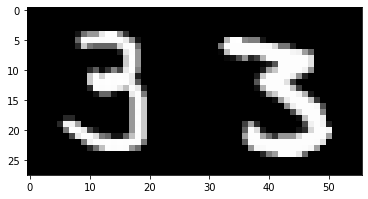

In [71]:
# Randomly display an example from the new dataset formed.
random = np.random.randint(dataset_size)
plt.imshow(x[random], cmap = 'gray')
print(y[random])

In [72]:
def ml_split(x, y):
    '''
    Multi hot encode the target variable and divide the data into train, validation and test data.
    '''
    # ml = MultiLabelBinarizer()
    # y = ml.fit_transform(y)

    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

    # ml = MultiLabelBinarizer()
    # y_train = ml.fit_transform(y_train)
    # y_valid = ml.transform(y_valid)
    # y_test = ml.transform(y_test)

    y_train = to_categorical(y_train, 100)
    y_valid = to_categorical(y_valid, 100)
    y_test = to_categorical(y_test, 100)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = ml_split(x, y)

In [76]:
def print_shapes():
    print('Shapes of dataset:')
    print('Training dataset:')
    print(X_train.shape, y_train.shape)
    print('\nValidation dataset:')
    print(X_valid.shape, y_valid.shape)
    print('\nTesting dataset:')
    print(X_test.shape, y_test.shape)

In [77]:
def format_input(features, labels):
    '''
    convert the numpy array (images), labels to tensor objects for training, add the channel dimension to the images.
    '''
    # features = tf.convert_to_tensor(features)
    features = tf.expand_dims(features, axis = -1)

    # labels = tf.convert_to_tensor(labels)

    return features, labels

In [79]:
X_train, y_train = format_input(X_train, y_train)
X_valid, y_valid = format_input(X_valid, y_valid)
X_test, y_test = format_input(X_test, y_test)

print_shapes()

Shapes of dataset:
Training dataset:
(64000, 28, 56, 1) (64000, 100)

Validation dataset:
(20000, 28, 56, 1) (20000, 100)

Testing dataset:
(16000, 28, 56, 1) (16000, 100)


In [80]:
def create_generator(bath_size):
    '''
    Creating generators for augmenting (none is mentioned right now), reshaping the data and for easy flow of data to the model.
    '''
    train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, dtype = 'float')
    train_datagen.fit(X_train)

    # valid_datagen = ImageDataGenerator(rescale = 1.0/255., dtype = 'float')

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = train_datagen.flow(X_valid, y_valid, batch_size=batch_size, seed = 42)
    test_generator = train_datagen.flow(X_test, y_test, batch_size=batch_size, seed = 42)

    return train_generator, valid_generator, test_generator

In [81]:
batch_size = 128
train_generator, valid_generator, test_generator = create_generator(batch_size)

## Multi Class Model

In [2]:
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_valid, y_valid) = mnist.load_data()

In [3]:
def reshape(x):
    # reshape the data into 28, 56
    new_image = np.zeros((28, 56), np.uint8)

    h1 = 28
    a = np.random.randint(0, 28)
    b = a + 28

    new_image[:h1, a:b] = x

    return new_image

new_train = []
new_valid = []
for image in x_train:
    new_train.append(reshape(image))

for image in x_valid:
    new_valid.append(reshape(image))

x_train = np.array(new_train)
x_valid = np.array(new_valid)

9


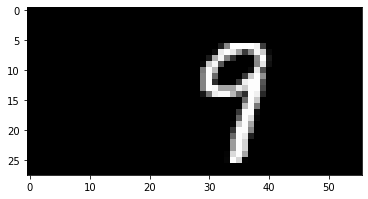

In [11]:
random = np.random.randint(len(x_train))
plt.imshow(x_train[random], cmap = 'gray')
print(y_train[random])

In [12]:
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    print(y_train.shape, y_valid.shape)

(60000, 10) (10000, 10)


In [13]:
print(x_train.shape, x_valid.shape)

(60000, 28, 56) (10000, 28, 56)


In [14]:
x_train = tf.expand_dims(x_train, axis = -1)
x_valid = tf.expand_dims(x_valid, axis = -1)

print(x_train.shape, x_valid.shape)

(60000, 28, 56, 1) (10000, 28, 56, 1)


In [15]:
    batch_size = 128
    train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, dtype = 'float')
    train_datagen.fit(x_train)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True, seed = 42)
    valid_generator = train_datagen.flow(x_valid, y_valid, batch_size=batch_size, seed = 42)

## Run Model 

In [93]:
# define cnn model
def define_model(shape=(28, 56, 1), num_classes=100):
    '''
    Function to create model.
    '''
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
	# model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
	# model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))
	# model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    # model.add(Conv2D(512, (3, 3), padding='same'))
    # model.add(Conv2D(512, (3, 3), padding='same'))
    # # model.add(MaxPooling2D((2, 2)))
    # model.add(Activation('relu'))

    model.add(Flatten())
    # model.add(Dense(512, activation = 'relu'))
    # model.add(Activation('relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Activation('relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
	# model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
    
model = define_model()

In [94]:
model.summary() # display model summary

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 28, 56, 32)        320       
_________________________________________________________________
activation_40 (Activation)   (None, 28, 56, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 28, 32)        0         
_________________________________________________________________
activation_41 (Activation)   (None, 14, 28, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 28, 64)        18496     
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 28, 64)       

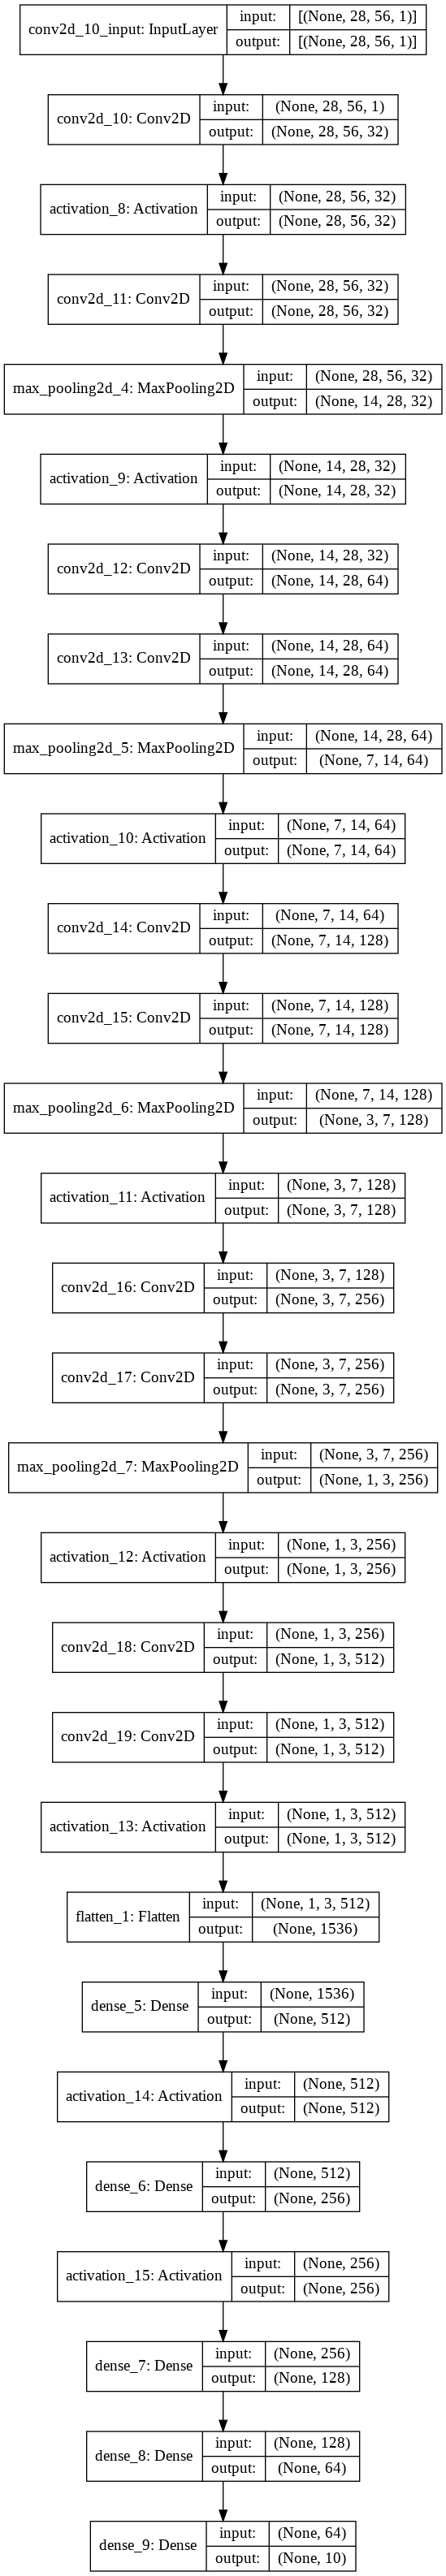

In [42]:
plot_model(model, show_shapes = True)  # plot model

In [85]:
def print_evaluate():
    train_acc = hist.history['accuracy']
    train_loss = hist.history['loss']

    valid_acc = hist.history['val_accuracy']
    valid_loss = hist.history['val_loss']
    epochs = range(len(train_acc))

    plt.plot(epochs, train_acc, 'r', label = 'Train Accuracy',)
    plt.plot(epochs, valid_acc, 'b', label = 'Validation Accuracy')
    # plt.plot(epochs, 0.75, 'y', label = 'Boundary')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    plt.plot(epochs, train_loss, 'r', label = 'Train Loss')
    plt.plot(epochs, valid_loss, 'b', label = 'Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    loss, accuracy = model.evaluate(test_generator, batch_size = batch_size)
    print(loss)
    print(int(accuracy * 100), '%')

In [86]:
# Define callbacks for the model, so that we can stop the training when required conditions are met.

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 75% accuracy so cancelling training!")
            self.model.stop_training = True

es = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 10, verbose = 1, restore_best_weights=True,
                                      min_delta = 0.02)
callbacks = myCallback()

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

In [95]:
opt = tf.keras.optimizers.Adam()
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

Epoch 1/200
500/500 [==============================] - 14s 27ms/step - loss: 2.2987 - accuracy: 0.4730 - val_loss: 0.1110 - val_accuracy: 0.9700
Epoch 2/200
500/500 [==============================] - 13s 27ms/step - loss: 0.1086 - accuracy: 0.9717 - val_loss: 0.0893 - val_accuracy: 0.9762
Epoch 3/200
500/500 [==============================] - 13s 27ms/step - loss: 0.0710 - accuracy: 0.9799 - val_loss: 0.0744 - val_accuracy: 0.9811
Epoch 4/200
500/500 [==============================] - 13s 26ms/step - loss: 0.0625 - accuracy: 0.9827 - val_loss: 0.0650 - val_accuracy: 0.9834
Epoch 5/200
500/500 [==============================] - 13s 26ms/step - loss: 0.0580 - accuracy: 0.9845 - val_loss: 0.0744 - val_accuracy: 0.9815
Epoch 6/200
500/500 [==============================] - 13s 26ms/step - loss: 0.0525 - accuracy: 0.9865 - val_loss: 0.0689 - val_accuracy: 0.9837
Epoch 7/200
500/500 [==============================] - 13s 26ms/step - loss: 0.0476 - accuracy: 0.9880 - val_loss: 0.1054 - val_ac

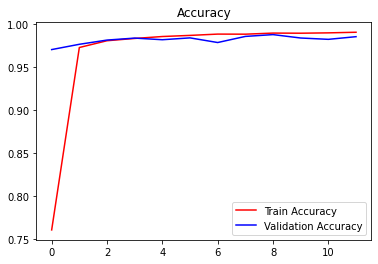

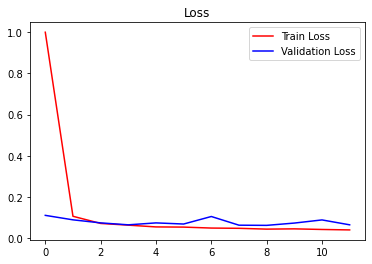

125/125 [==============================] - 1s 10ms/step - loss: 0.0946 - accuracy: 0.9751
0.0946277603507042
97 %


In [96]:
epochs = 200

hist = model.fit(train_generator, epochs = epochs, validation_data = valid_generator, callbacks=[callbacks, es])
print_evaluate()

## Extras

In [23]:
n = 0
for layer in model.layers:
    if 'Conv2D' in str(layer):
        n +=1
        if n<9:
            layer.trainable = False
        else:
            pass

n

10

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 56, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 28, 32)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 14, 28, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 28, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 28, 64)       

In [97]:
# model.save('mnist-2-100_classes.h5')